In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['figure.figsize'] = [18, 8]

# tk libs
from lib.objs.tkpaths import Site
from lib.objs.predictor import Predictor
from lib.io.matlab import ReadGowMat, ReadCoastMat, ReadEstelaMat
from lib.estela import spatial_gradient, mask_from_poly
from lib.tcyclone import Extract_Circle
from lib.plotting.ESTELA import Plot_ESTELA_Globe


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

DB = site.pc.DB                           # common database
ST = site.pc.site                         # site database
PR = site.params                          # site parameters

# input files
p_est_coastmat = ST.ESTELA.coastmat       # estela coast (.mat)
p_est_datamat = ST.ESTELA.estelamat       # estela data (.mat)
p_gow_mat = ST.ESTELA.gowpoint            # gow point (.mat)
p_wvs_parts_p1 = ST.WAVES.partitions_p1 
p_slp = ST.ESTELA.slp                     # site slp data (.nc)
p_hist_tcs = DB.TCs.noaa_fix              # WMO historical TCs

# output files
p_est_pred = ST.ESTELA.pred_slp           # estela slp predictor
p_dbins = ST.ESTELA.hydrographs           # intradaily mu tau hydrographs

# parameters for KMA_REGRESSION_GUIDED
kma_date_ini = PR.ESTELA_KMA_RG.date_ini
kma_date_end = PR.ESTELA_KMA_RG.date_end
num_clusters = int(PR.ESTELA_KMA_RG.num_clusters)
kmarg_alpha = float(PR.ESTELA_KMA_RG.alpha)

# wave point lon, lat, and radius for TCs selection
pnt_lon = float(PR.WAVES.point_longitude)
pnt_lat = float(PR.WAVES.point_latitude)
r2 = float(PR.TCS.r2)   # smaller one


In [15]:
# --------------------------------------
# load sea polygons for mask generation
ls_sea_poly = ReadCoastMat(p_est_coastmat)

# load estela data 
xds_est = ReadEstelaMat(p_est_datamat)
estela_D = xds_est.D_y1993to2012

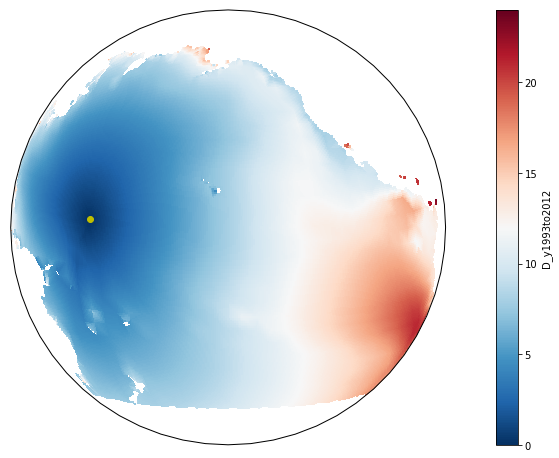

In [17]:
# plot estela days and wave point
Plot_ESTELA_Globe(pnt_lon, pnt_lat, estela_D)

In [3]:
# --------------------------------------
# load waves data from .mat gow file
xds_WAVES = ReadGowMat(p_gow_mat)
print('\nResampling waves data to daily mean...')

# calculate Fe (from GOW waves data)
hs = xds_WAVES.hs
tm = xds_WAVES.t02
Fe = np.multiply(hs**2,tm)**(1.0/3)
xds_WAVES.update({
    'Fe':(('time',), Fe)
})

# select time window and do data daily mean
xds_WAVES = xds_WAVES.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()
print xds_WAVES



Resampling waves data to daily mean...
<xarray.Dataset>
Dimensions:  (time: 11689)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
Data variables:
    fp       (time) float64 0.1037 0.09292 0.09458 ... 0.07067 0.06604 0.07121
    hs       (time) float64 3.105 2.933 2.88 2.24 ... 2.177 2.395 2.55 2.305
    spr      (time) float64 39.06 40.38 36.42 38.68 ... 47.4 41.82 39.79 42.83
    t02      (time) float64 6.059 6.032 5.998 5.773 ... 6.9 8.265 7.428 6.794
    hsCal    (time) float64 3.191 2.935 2.898 2.101 ... 2.006 2.09 2.379 2.23
    dir      (time) float64 58.25 55.27 58.52 55.72 ... 159.7 351.0 165.9 10.58
    Fe       (time) float64 3.879 3.729 3.677 3.07 ... 3.198 3.619 3.641 3.304


In [4]:
# --------------------------------------
# load SLP (use xarray saved predictor data) 
xds_SLP_site = xr.open_dataset(p_slp)

# select time window and do data daily mean
print('\nResampling SLP data to daily mean...')
xds_SLP_day = xds_SLP_site.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()
print 'SLP: ',xds_SLP_day.time.values[0],' - ',xds_SLP_day.time.values[-1]

# calculate daily gradients
print('\nCalculating SLP spatial gradient...')
xds_SLP_day = spatial_gradient(xds_SLP_day, 'SLP')

# generate land mask with land polygons 
print('\nReading land mask and ESTELA data for SLP...')
xds_SLP_day = mask_from_poly(
    xds_SLP_day, ls_sea_poly, 'mask_land')

# resample estela to site mesh
xds_est_site = xds_est.sel(
    longitude = xds_SLP_site.longitude,
    latitude = xds_SLP_site.latitude,
)
estela_D = xds_est_site.D_y1993to2012

# generate SLP mask using estela
mask_est = np.zeros(estela_D.shape)
mask_est[np.where(estela_D<1000000000)]=1

xds_SLP_day.update({
    'mask_estela':(('latitude','longitude'), mask_est)
})
print xds_SLP_day



Resampling SLP data to daily mean...
SLP:  1979-01-22T00:00:00.000000000  -  2011-01-22T00:00:00.000000000

Calculating SLP spatial gradient...

Reading land mask and ESTELA data for SLP...
<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float32 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float32 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_land     (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    mask_estela   (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0


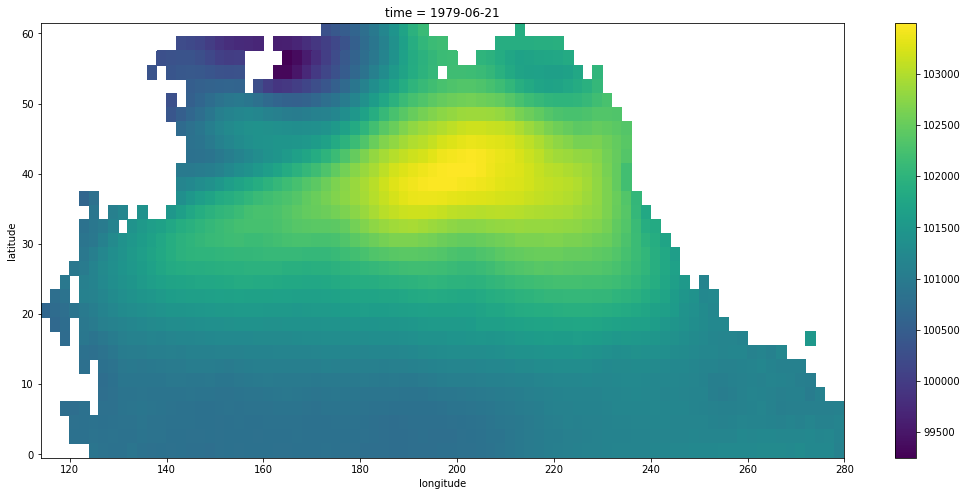

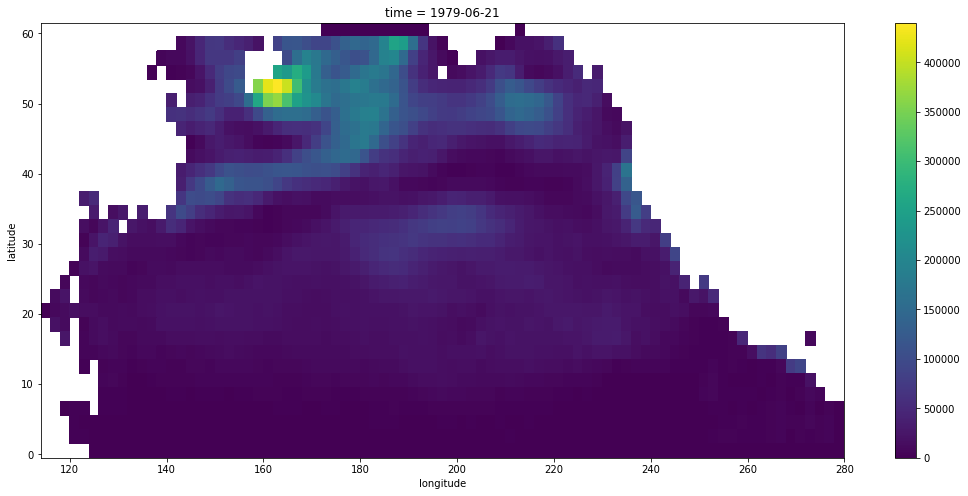

In [18]:
# plot SLP predictor and SLP_gradient
tp = 150
xds_SLP_day.SLP.isel(time=tp).where(xds_SLP_day.mask_estela==1).plot()
plt.show()
xds_SLP_day.SLP_gradient.isel(time=tp).where(xds_SLP_day.mask_estela==1).plot()
plt.show()

In [6]:
# --------------------------------------
# Use a tesla-kit predictor object
pred = Predictor(p_est_pred)
pred.data = xds_SLP_day

# Calculate PCA (dynamic estela predictor)
print('\nPrincipal Component Analysis (ESTELA predictor)...')
pred.Calc_PCA_EstelaPred('SLP', estela_D)

# save predictor data
pred.Save()


Principal Component Analysis (ESTELA predictor)...


/Users/nico/Projects/TESLA-kit/source/teslakit/lib/PCA.py:213: RuntimeWarning: invalid value encountered in divide
  pred_norm = (dp_ur_nonan[:,:] - pred_mean) / pred_std


Principal Components Analysis COMPLETE


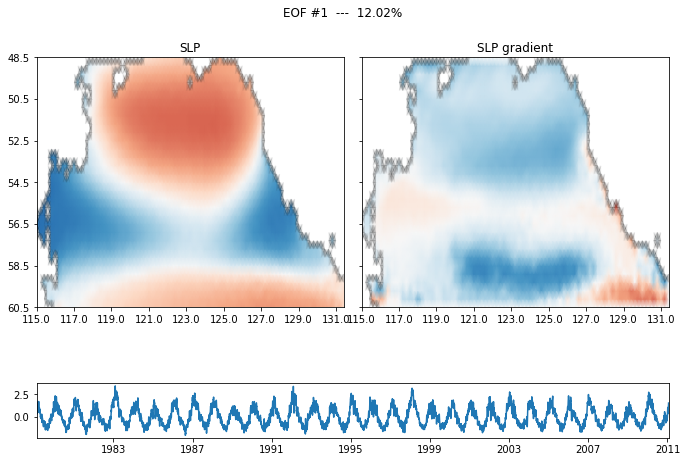

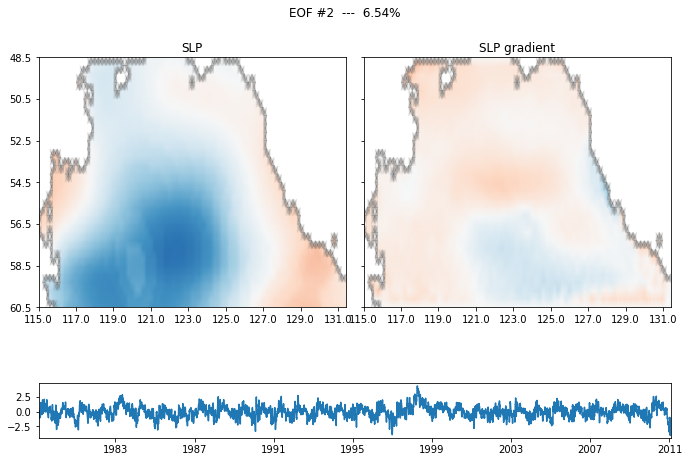

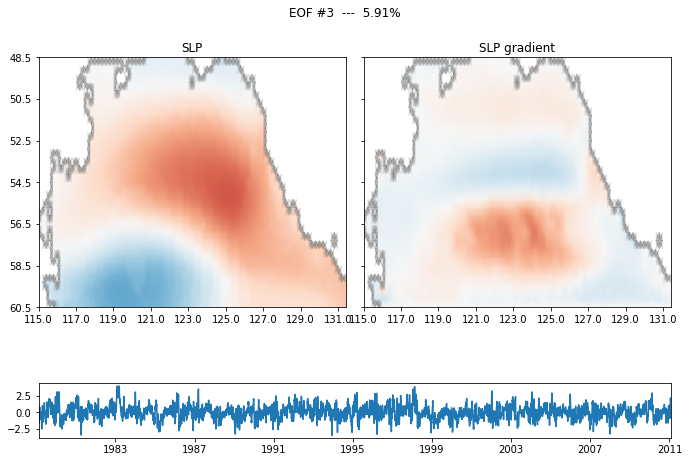

In [19]:
# plot PCA EOFs
n_EOFs = 3
pred.Plot_EOFs_EstelaPred(n_EOFs, show=True)

In [8]:
# Calculate KMA (regression guided with WAVES data)
print('\nKMA Classification (regression guided: waves)...')

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    xds_WAVES, ['hs','t02','Fe'],
    kmarg_alpha)

# save predictor data
pred.Save()


KMA Classification (regression guided: waves)...
KMA:  1979-02-12T00:00:00.000000000  -  2011-01-22T00:00:00.000000000


/Users/nico/Projects/TESLA-kit/source/venv/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


KMEANS regression-guided classification COMPLETE.


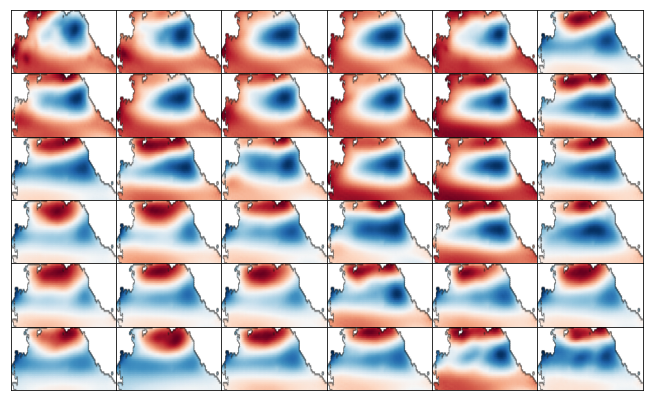

In [21]:
# plot KMA clusters
pred.Plot_KMArg_clusters_datamean('SLP', show=True, mask_name='mask_estela')

In [10]:
# --------------------------------------
# load storms, find inside circle and modify predictor KMA 
xds_wmo_fix = xr.open_dataset(p_hist_tcs)

# extract TCs inside circle using GOW point as center 
print(
'\nExtracting Historical TCs from WMO database...\n \
Lon = {0:.2f}º , Lat = {1:.2f}º, R2  = {2:6.2f}º'.format(
    pnt_lon, pnt_lat, r2)
)

_, xds_in = Extract_Circle(
    xds_wmo_fix, pnt_lon, pnt_lat, r2)

storm_dates = xds_in.dmin_date.values[:]
storm_categs = xds_in.category.values[:]

# modify predictor KMA with circle storms data
print('\nAdding Historical TCs to SLP_PREDICTOR KMA_RG bmus...')
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)



Extracting Historical TCs from WMO database...
 Lon = 167.50º , Lat = 9.75º, R2  =   4.00º


/Users/nico/Projects/TESLA-kit/source/teslakit/lib/tcyclone.py:55: RuntimeWarning: invalid value encountered in less
  pos_in = np.where(dist<r)[0][:]
/Users/nico/Projects/TESLA-kit/source/teslakit/lib/tcyclone.py:77: FutureWarning: In the future, NAT != NAT will be True rather than False.
  lambda a: a!= np.datetime64('NaT'), time[i_storm][:]



Adding Historical TCs to SLP_PREDICTOR KMA_RG bmus...


In [11]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs
xds_WAVES_p1 = ReadGowMat(p_wvs_parts_p1)

print('\nCalculating MU TAU hydrographs')
d_bins = pred.Calc_MU_TAU_Hydrographs(xds_WAVES_p1)

# store hydrographs
pickle.dump(d_bins, open(p_dbins, 'wb'))

# TODO: plot report hydrographs



Calculating MU TAU hydrographs
bin00 calculated
bin01 calculated
bin02 calculated
bin03 calculated
bin04 calculated
bin05 calculated
bin06 calculated
bin07 calculated
bin08 calculated
bin09 calculated
bin10 calculated
bin11 calculated
bin12 calculated
bin13 calculated
bin14 calculated
bin15 calculated
bin16 calculated
bin17 calculated
bin18 calculated
bin19 calculated
bin20 calculated
bin21 calculated
bin22 calculated
bin23 calculated
bin24 calculated
bin25 calculated
bin26 calculated
bin27 calculated
bin28 calculated
bin29 calculated
bin30 calculated
bin31 calculated
bin32 calculated
bin33 calculated
bin34 calculated
bin35 calculated
